In [75]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error

# Ensure reproducibility
tf.keras.utils.set_random_seed(313)
tf.config.experimental.enable_op_determinism()

In [76]:
df = pd.read_csv('Amazon_temperature_student.csv')
print(df.head())

   year  month  temperature   TSA  ENSO   NAO   TNA
0  1982      1    25.938068  0.03  0.13 -1.55  0.19
1  1982     10    27.525936 -0.11  1.99 -0.29 -0.34
2  1982     11    27.586092 -0.28  1.92  1.55 -0.46
3  1982     12    27.096022 -0.17  2.20  1.56 -0.50
4  1982      2    25.861292 -0.20 -0.17  0.86 -0.07


In [77]:
features = df[["ENSO", "TSA", "TNA", "NAO"]].values
target = df["temperature"].values

In [78]:
X_temp, X_test, y_temp, y_test = train_test_split(features, target, test_size=0.2, random_state=313)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=313)

print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

Train: 294, Validation: 99, Test: 99


In [79]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [80]:
plot_samples = 100

In [81]:
nnet = Sequential()
nnet.add(Dense(5, input_dim=4, activation='relu'))   # 4×5 + 5 = 25
nnet.add(Dense(1, activation='linear'))              # 2×1 + 1 = 3
nnet.compile(
    loss='mean_absolute_error',
    optimizer=Adam(learning_rate=0.01),
    metrics=['mae']
)

D:\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [82]:
early_stop = EarlyStopping(
    monitor='val_loss',     # 监控验证集损失
    patience=10,            # 容忍轮数
    restore_best_weights=True  # 恢复验证损失最小时的模型参数
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 


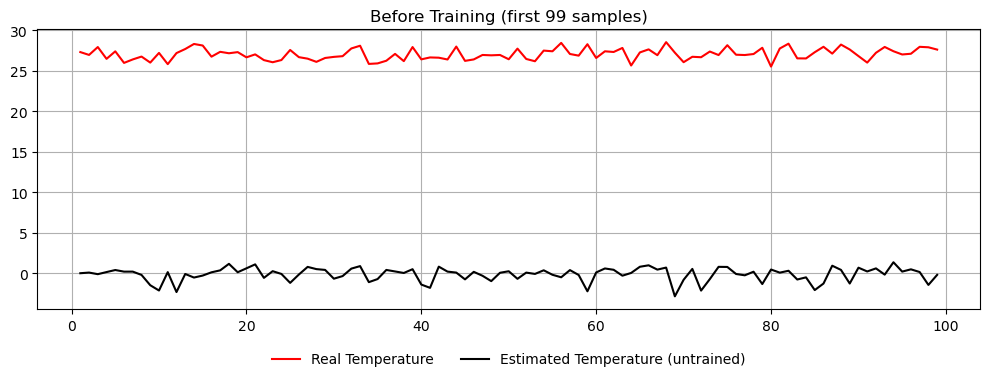

In [83]:
# Untrained prediction
y_pred_init = nnet.predict(X_test_scaled)
n_plot = min(plot_samples, len(y_test))
x = np.arange(1, n_plot + 1)

plt.figure(figsize=(10, 4))
plt.plot(x, y_test[:n_plot], "r-", label="Real Temperature")
plt.plot(x, y_pred_init[:n_plot], "k-", label="Estimated Temperature (untrained)")
plt.title(f"Before Training (first {n_plot} samples)")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.25), ncol=2, frameon=False)
plt.grid()
plt.tight_layout()
plt.show()

In [84]:
history = nnet.fit(
    X_train_scaled, 
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],   
    verbose=1
)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 27.1677 - mae: 27.1677 - val_loss: 26.7139 - val_mae: 26.7139
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 26.6210 - mae: 26.6210 - val_loss: 26.1952 - val_mae: 26.1952
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 26.0904 - mae: 26.0904 - val_loss: 25.6695 - val_mae: 25.6695
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 25.5452 - mae: 25.5452 - val_loss: 25.1046 - val_mae: 25.1046
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 24.9484 - mae: 24.9484 - val_loss: 24.4652 - val_mae: 24.4652
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 24.2667 - mae: 24.2667 - val_loss: 23.7187 - val_mae: 23.7187
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 23.4649 - mae: 23.4649 - val_loss: 22.8352 - val_mae: 22.8352
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 22.5097 - mae: 22.5097 - val_loss: 21.7876 - val_mae: 21.7876
Epoch 9/100
10/10 ━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


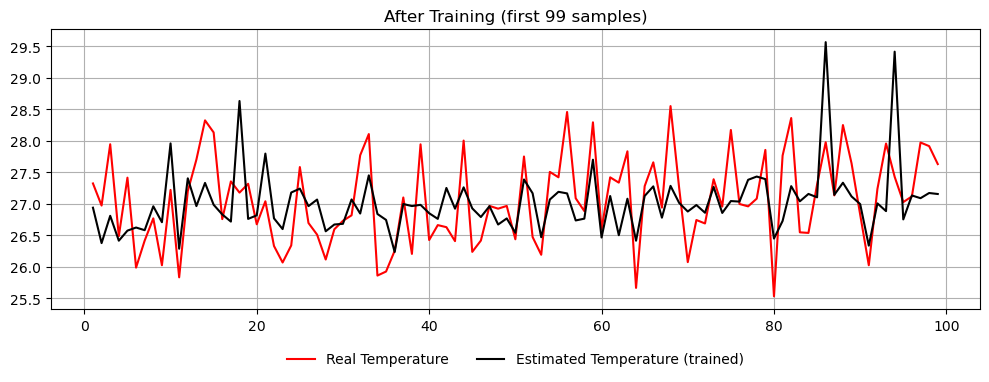

In [85]:
# Prediction after training
# ----------------------------------------------------------
y_pred = nnet.predict(X_test_scaled)


n_plot = min(len(X_test), len(y_test))
x = np.arange(1, n_plot + 1)

plt.figure(figsize=(10, 4))
plt.plot(x, y_test[:n_plot], "r-", label="Real Temperature")
plt.plot(x, y_pred[:n_plot], "k-", label="Estimated Temperature (trained)")
plt.title(f"After Training (first {n_plot} samples)")
plt.grid()
plt.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=2,
    frameon=False,
)
plt.tight_layout()
plt.show()

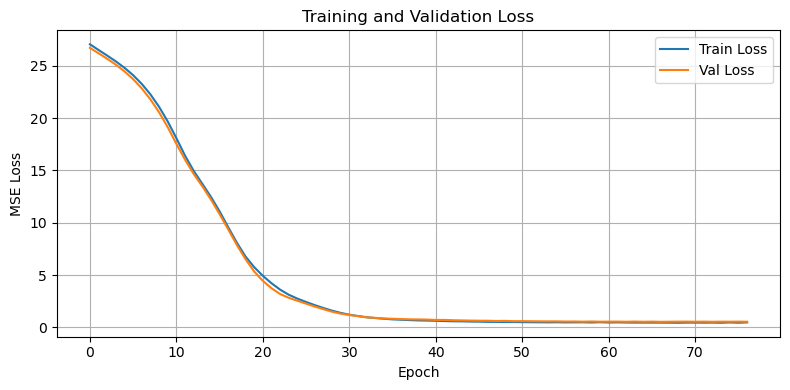

In [86]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [87]:
y_true = y_test
y_pred = nnet.predict(X_test_scaled).flatten()

# 计算均值
y_mean = np.mean(y_true)
yhat_mean = np.mean(y_pred)

# Pearson 相关系数 r
numerator = np.sum((y_true - y_mean) * (y_pred - yhat_mean))
denominator = np.sqrt(np.sum((y_true - y_mean) ** 2)) * np.sqrt(np.sum((y_pred - yhat_mean) ** 2))
r = numerator / denominator

# Mean Absolute Error (MAE)
mae = np.mean(np.abs(y_true - y_pred))

# 打印结果
print("\n===== Regression Evaluation (Test Set) =====")
print(f"Pearson Correlation Coefficient (r): {r:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

===== Regression Evaluation (Test Set) =====
Pearson Correlation Coefficient (r): 0.4529
Mean Absolute Error (MAE): 0.5287


In [63]:
years = sorted(df['year'].unique())
print(years)

[1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


In [64]:
import random

df = pd.read_csv("Amazon_temperature_student.csv")

feature_cols = ['TSA', 'ENSO', 'NAO', 'TNA']
target_col = 'temperature'

# === (p) 按年份划分 ===
years = sorted(df['year'].unique())
n_years = len(years)

# 打乱年份顺序
random.seed(42)  # 设置随机种子以保证可复现
random.shuffle(years)

# 按比例划分
n_train = int(0.6 * n_years)
n_val = int(0.2 * n_years)

train_years = years[:n_train]
val_years = years[n_train:n_train + n_val]
test_years = years[n_train + n_val:]

train_df = df[df['year'].isin(train_years)].copy()
val_df = df[df['year'].isin(val_years)].copy()
test_df = df[df['year'].isin(test_years)].copy()

# === (q) 应用特征预处理（使用训练集拟合）===
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(train_df[feature_cols])
X_val = X_scaler.transform(val_df[feature_cols])
X_test = X_scaler.transform(test_df[feature_cols])

# 目标值归一化（仅拟合训练集）
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(train_df[[target_col]])
y_val = y_scaler.transform(val_df[[target_col]])
y_test = y_scaler.transform(test_df[[target_col]])

model = Sequential([
    Dense(4, input_dim=4, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(
    loss='mean_squared_error',
    optimizer=Adam(learning_rate=0.02),
    metrics=['mae']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


D:\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.1883 - mae: 0.8701 - val_loss: 1.0749 - val_mae: 0.8463
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8094 - mae: 0.7574 - val_loss: 0.9673 - val_mae: 0.8210
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7848 - mae: 0.7529 - val_loss: 0.8903 - val_mae: 0.7802
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7165 - mae: 0.6953 - val_loss: 0.8702 - val_mae: 0.7687
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6982 - mae: 0.6771 - val_loss: 0.8244 - val_mae: 0.7418
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6816 - mae: 0.6753 - val_loss: 0.8131 - val_mae: 0.7369
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6732 - mae: 0.6740 - val_loss: 0.8150 - val_mae: 0.7405
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6634 - mae: 0.6675 - val_loss: 0.8133 - val_mae: 0.7408
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6555 - mae: 0.6640 - val

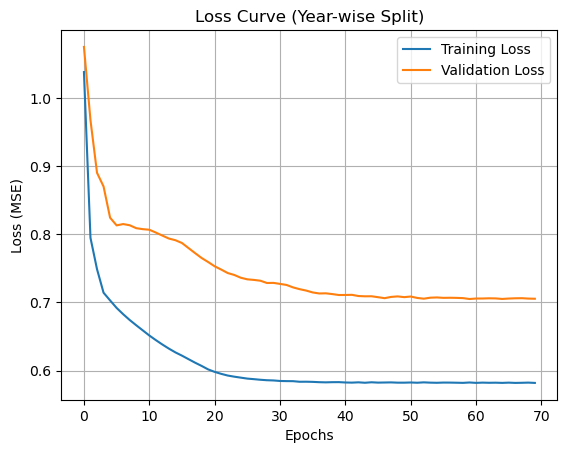

In [68]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Loss Curve (Year-wise Split)")
plt.legend()
plt.grid(True)
plt.show()

In [74]:
# 模型预测 + 反归一化
y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test)

# Pearson r
r, _ = pearsonr(y_true.flatten(), y_pred.flatten())

# MAE
mae = mean_absolute_error(y_true, y_pred)

# 打印结果
print("\n===== Regression Evaluation (Test Set) =====")
print(f"Pearson Correlation Coefficient (r): {r:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

===== Regression Evaluation (Test Set) =====
Pearson Correlation Coefficient (r): 0.5610
Mean Absolute Error (MAE): 0.4470
